# **Image Colourisation with Auto-Encoders**

Auto-encoders are models composed of encoders and decoders. The encoder is used to compress the input into a latent-space representation while the decoder reconstructs the output from this representation.

In this notebook, we'll use Auto-Encoders to colourise *black & white* images. The underlying structure of this model is that of a U-Net.

**<a href="https://www.kaggle.com/code/theblackmamba31/autoencoder-grayscale-to-color-image" target="_parent">Original Code</a>**

#### Run these 2 code blocks if running on Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab Notebooks/Dissertation/src"

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Dissertation/src


In [ ]:
! cp -r "../dataset" "/content/dataset/"

In [2]:
def import_script(name):
  from google.colab import files
  src = list(files.upload().values())[0]
  open(f'{name}.py','wb').write(src)

## **1. Downloading and Pre-Processing the Dataset**
---
The dataset used for this model is made up of **_4117_** RGB portraits.

We will now resize images to $160px$ and return two lists containing $grayscale$ and $coloured$ images. So far the entire dataset will be used but may reduce the amount of images due to computational limitations. 

- The dataset will be split into 80% training and 20% testing using the `train_test_split` function.
- Data is not categorical since they are all portraits, so no stratification will be applied to the dataset.

In [ ]:
import importlib, utils

In [ ]:
importlib.reload(utils)
from utils import *

gray_train, gray_test, colour_train, colour_test = get_dataset("portraits", train_size=0.8)

print(f'Training Images (GRAY): {gray_train.shape[0]} Images, {gray_train.shape[2]} x {gray_train.shape[1]}')
print(f'Training Images (COLOUR): {colour_train.shape[0]} Images, {colour_train.shape[2]} x {colour_train.shape[1]}')
print()
print(f'Testing Images (GRAY): {gray_test.shape[0]} Images, {gray_test.shape[2]} x {gray_test.shape[1]}')
print(f'Testing Images (COLOUR): {colour_test.shape[0]} Images, {colour_test.shape[2]} x {colour_test.shape[1]}')

COLOUR: 100%|██████████| 4117/4117 [01:17<00:00, 53.33it/s]


[SUCCESS] Prepocessing done.



GRAY: 100%|██████████| 4117/4117 [00:58<00:00, 70.64it/s]


[SUCCESS] Prepocessing done.

Training Images (GRAY): 3293 Images, 160 x 160
Training Images (COLOUR): 3293 Images, 160 x 160

Testing Images (GRAY): 824 Images, 160 x 160
Testing Images (COLOUR): 824 Images, 160 x 160


## **2. Defining the Model**
---
In this section, we will create our auto-encoder model using `Keras`. Three functions will be defined to simplify the implementation of the auto-encoder: `down`, `up` and `model`.

In [ ]:
import keras
from keras import layers
from keras.models import Sequential

def down(filters, kernel_size, apply_batch_normalisation = True):
    downsample = Sequential()
    downsample.add(layers.Conv2D(filters, kernel_size, padding="same", strides=2))
    
    if apply_batch_normalisation:
        downsample.add(layers.BatchNormalization())
        downsample.add(layers.LeakyReLU())
        
    return downsample

def up(filters, kernel_size, dropout=False):
    upsample = Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size, padding="same", strides=2))

    if dropout:
        upsample.add(layers.Dropout(0.2))

    upsample.add(layers.LeakyReLU())
    return upsample

### Auto-Encoder Structure
---
#### Encoder
Our encoder consists of 5 downsampling blocks, each containing a kernel of size $3$. Each layer consists of a convolutional layer followed by Batch Normalisation and a ReLU activation function.

#### Decoder
Similarly, the decoder consists of 5 upsampling blocks, each increasing the spatial dimensions of the output. We will also use skip connections to connect the output of the upsampling block with its corresponding downsampling block to preserve details.

In [ ]:
def model():
    inputs = layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3])
    
    # downsampling
    down_1 = down(128, (3,3), False)(inputs)
    down_2 = down(128, (3,3), False)(down_1)
    down_3 = down(256, (3,3), True)(down_2)
    down_4 = down(512, (3,3), True)(down_3)
    down_5 = down(512, (3,3), True)(down_4)
    
    # upsampling
    up_1 = up(512, (3,3), False)(down_5)
    up_1 = layers.concatenate([up_1, down_4])

    up_2 = up(256, (3,3), False)(up_1)
    up_2 = layers.concatenate([up_2, down_3])

    up_3 = up(128, (3,3), False)(up_2)
    up_3 = layers.concatenate([up_3, down_2])
    
    up_4 = up(128, (3,3), False)(up_3)
    up_4 = layers.concatenate([up_4, down_1])
    
    up_5 = up(3, (3,3), False)(up_4)
    up_5 = layers.concatenate([up_5, inputs])

    output = layers.Conv2D(3, (2, 2), strides=1, padding="same")(up_5)
    return keras.Model(inputs=inputs, outputs=output)

In [ ]:
importlib.reload(utils)
from utils import *

paths = generate_paths(MODELS.AE) # generating a new path for an auto-encoder model
model_path, results_path, run_path, images_path = paths["WEIGHTS"], paths["RESULTS"], paths["RUN"], paths["IMAGES"]
print(model_path, results_path, run_path, images_path)

./models/ae/16-05-2023/run_5/weights.h5 ./models/ae/16-05-2023/run_5/results ./models/ae/16-05-2023/run_5 ./models/ae/16-05-2023/run_5/results/images


In [ ]:
model = model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_10 (Sequential)     (None, 80, 80, 128)  3584        ['input_2[0][0]']                
                                                                                                  
 sequential_11 (Sequential)     (None, 40, 40, 128)  147584      ['sequential_10[0][0]']          
                                                                                                  
 sequential_12 (Sequential)     (None, 20, 20, 256)  296192      ['sequential_11[0][0]']    

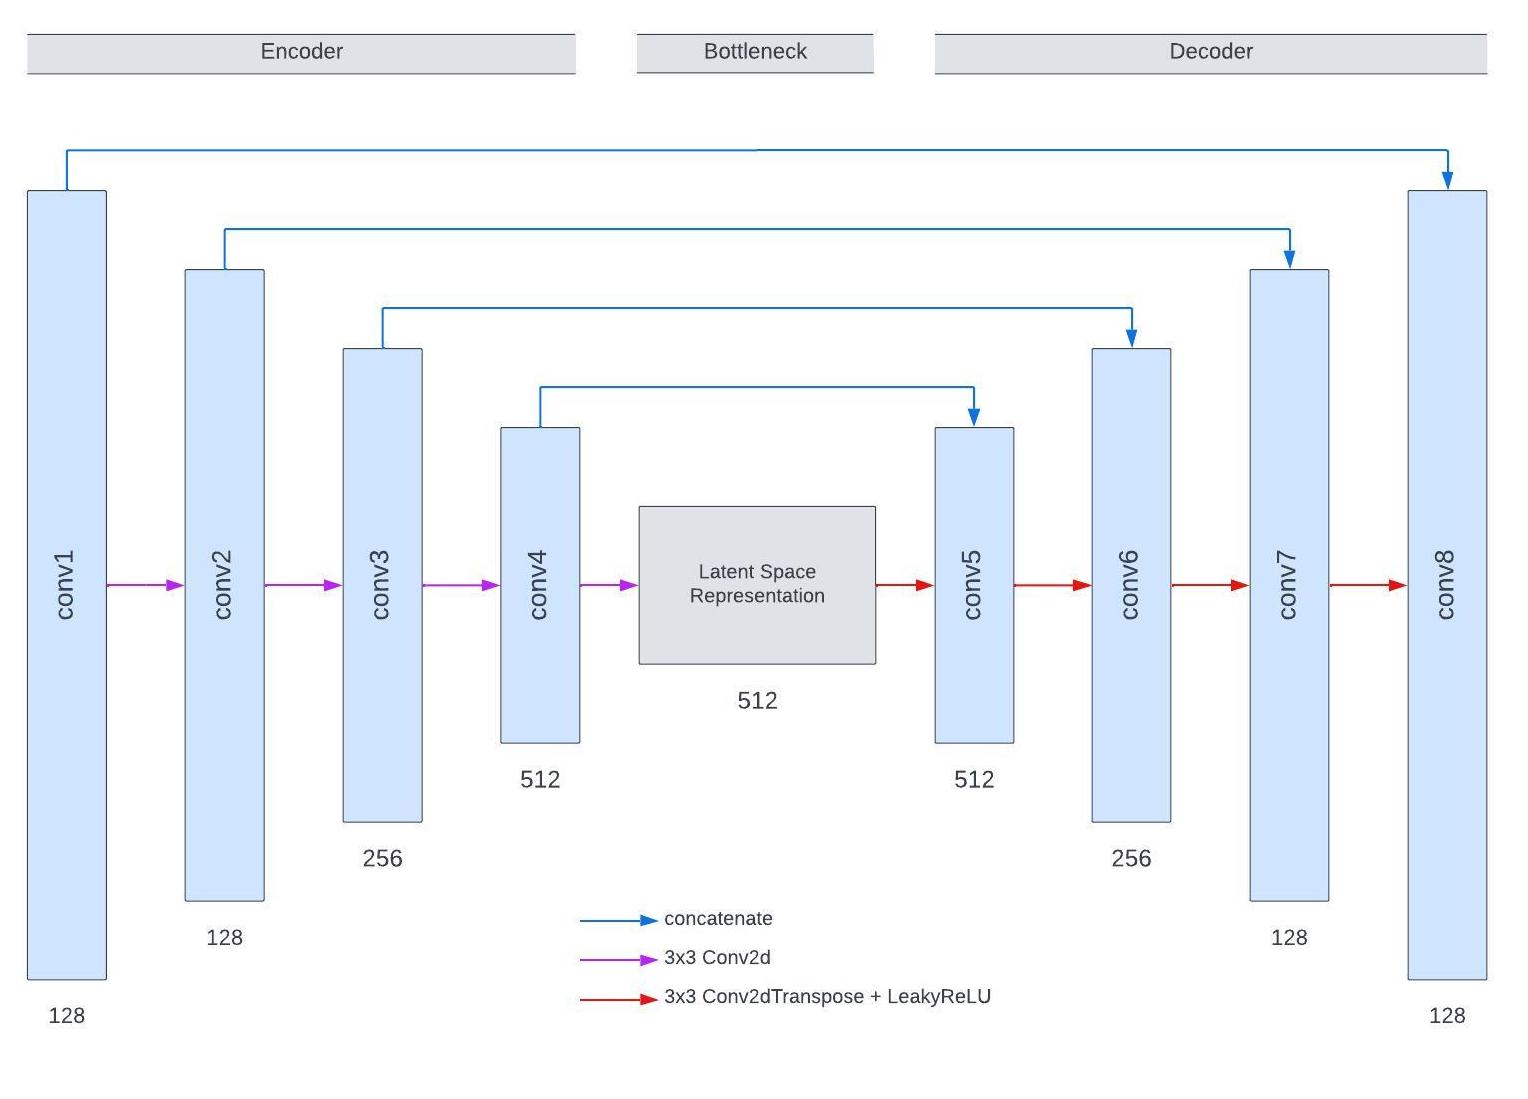

The model will be trained using 50 epochs and a batch size of 50 as these generated the most plausible results. We use the `ModelCheckpoint` function to save the best weights only during training while monitoring the accuracy.

- Mean-Absolute Error (MAE) will be used as our loss function.
- The Adam Optimiser is also used alongside the MAE loss function.

In [ ]:
importlib.reload(utils)
from utils import *
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

mae = tf.keras.losses.MeanAbsoluteError()
acc = tf.keras.metrics.Accuracy()
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss = mae,
    metrics = ['acc']
)


model_checkpoint = ModelCheckpoint(
    filepath=model_path,
    monitor='acc',
    mode='max',
    save_weights_only=True,
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.1,      
    patience=5,                 # Number of epochs with no improvement after which learning rate will be reduced.
    min_lr=1e-5,
    mode="min"
)

early_stopping = EarlyStopping(
    monitor='loss',             # Metric to monitor
    min_delta=0.05,             # Minimum change in the monitored metric to qualify as improvement
    patience=5,                 # Number of epochs to wait before stopping the training process
    verbose=1,                  # Verbosity mode
    mode='min',                 # Direction of improvement ('auto', 'min', or 'max')
    restore_best_weights=True   # Restore the weights from the epoch with the best monitored metric value
)

csv_logger = tf.keras.callbacks.CSVLogger(filename=os.path.join(run_path, "training.csv"))
model.fit(gray_train, colour_train,
    epochs=50,
    batch_size=50,
    callbacks=[model_checkpoint, csv_logger]
)
model.save(f"{run_path}/model")

Epoch 1/50
66/66 [==============================] - 17s 236ms/step - loss: 0.0183 - acc: 0.8268
Epoch 2/50
66/66 [==============================] - 16s 246ms/step - loss: 0.0160 - acc: 0.8356
Epoch 3/50
66/66 [==============================] - 16s 249ms/step - loss: 0.0153 - acc: 0.8457
Epoch 4/50
66/66 [==============================] - 16s 240ms/step - loss: 0.0156 - acc: 0.8398
Epoch 5/50
66/66 [==============================] - 16s 250ms/step - loss: 0.0152 - acc: 0.8466
Epoch 6/50
66/66 [==============================] - 16s 242ms/step - loss: 0.0155 - acc: 0.8408
Epoch 7/50
66/66 [==============================] - 16s 243ms/step - loss: 0.0156 - acc: 0.8460
Epoch 8/50
66/66 [==============================] - 17s 254ms/step - loss: 0.0149 - acc: 0.8481
Epoch 9/50
66/66 [==============================] - 16s 244ms/step - loss: 0.0153 - acc: 0.8465
Epoch 10/50
66/66 [==============================] - 17s 253ms/step - loss: 0.0149 - acc: 0.8512
Epoch 11/50
66/66 [====================

## **3. Quantitative Analysis**
---

In [ ]:
model.load_weights(model_path)

In [ ]:
model.evaluate(gray_test, colour_test)

In [ ]:
importlib.reload(utils)
from utils import *

csv_data = []
for i, img_idx in enumerate(range(50)):
    predicted = model.predict(gray_test[img_idx].reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3), verbose=0)
    predicted = np.clip(predicted, 0.0, 1.0).reshape(IMAGE_SIZE, IMAGE_SIZE, 3)

    plot_images(colour_test[img_idx], gray_test[img_idx], predicted, f"{images_path}/{str(i+1)}")
    stats = get_metrics(f"{images_path}/{str(i+1)}/ground_truth.png", f"{images_path}/{str(i+1)}/colourised.png")
    stats["Image"] = i + 1
    csv_data.append(stats)

write_to_csv(f"{results_path}/results.csv", csv_data)

Calculating the metrics for the images colourised with ChromaGAN and DeOldify.

In [ ]:
!python metrics.py "./models/chroma_gan"
!python metrics.py "./models/de_oldify"

2023-05-31 11:06:40.814308: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-31 11:06:43.865698: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


## **4. Qualitative Analysis**
---

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

responses = pd.read_csv("../survey/ae/responses.csv")
column_names = {
    "Timestamp": "timestamp",
    "Do you specialise in any profession related to art and/or photography?": "specialise",
    "Which of the following images do you think was colourised by an artificial intelligence algorithm?": "S1Q1",
    "Which of the following images do you think was colourised by an artificial intelligence algorithm?.1": "S1Q2",
    "Which of the following images do you think was colourised by an artificial intelligence algorithm?.2": "S1Q3",
    "Which of the following images do you think was colourised by an artificial intelligence algorithm?.3": "S1Q4",
    "Which of the following images do you think was colourised by an artificial intelligence algorithm?.4": "S1Q5",
    "Which of the following images do you think was colourised by an artificial intelligence algorithm?.5": "S1Q6",
    "Which of the following images do you think was colourised by an artificial intelligence algorithm?.6": "S1Q7",
    "Which of the following images do you think was colourised by an artificial intelligence algorithm?.7": "S1Q8",
    "Which of the following images do you think was colourised by an artificial intelligence algorithm?.8": "S1Q9",
    "Which of the following images do you think was colourised by an artificial intelligence algorithm?.9": "S1Q10",
    "How realistic does the following image look?": "S2Q1",
    "How realistic does the following image look?.1": "S2Q2",
    "How realistic does the following image look?.2": "S2Q3",
    "How realistic does the following image look?.3": "S2Q4",
    "How realistic does the following image look?.4": "S2Q5",
    "How realistic does the following image look?.5": "S2Q6",
    "How realistic does the following image look?.6": "S2Q7",
    "How realistic does the following image look?.7": "S2Q8",
    "How realistic does the following image look?.8": "S2Q9",
    "How realistic does the following image look?.9": "S2Q10",
}
responses.rename(columns=column_names, inplace=True)
responses.timestamp = pd.to_datetime(responses.timestamp)

responses.head()

/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname EEST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


,timestamp,specialise,S1Q1,S1Q2,S1Q3,S1Q4,S1Q5,S1Q6,S1Q7,S1Q8,...,S2Q1,S2Q2,S2Q3,S2Q4,S2Q5,S2Q6,S2Q7,S2Q8,S2Q9,S2Q10
0,2023-05-25 13:45:37,No,A,A,C,B,D,C,C,C,...,4,1,3,1,2,3,1,4,1,4
1,2023-05-25 13:49:46,Yes,D,B,D,B,A,B,D,A,...,3,3,2,4,3,2,4,4,3,2
2,2023-05-25 13:54:38,No,D,A,B,D,C,D,A,C,...,5,4,3,3,3,3,4,5,3,4
3,2023-05-25 13:57:51,No,D,D,A,C,C,C,A,D,...,5,4,1,3,2,2,5,4,3,4
4,2023-05-25 14:00:18,Yes,D,C,C,D,B,C,B,B,...,4,5,3,2,1,5,5,3,2,5


In [ ]:
# Define a dictionary of column names and their corresponding correct answers
correct_answers = {
    'S1Q1': 'C',
    'S1Q2': 'D',
    'S1Q3': 'D',
    'S1Q4': 'B',
    'S1Q5': 'A',
    'S1Q6': 'C',
    'S1Q7': 'B',
    'S1Q8': 'C',
    'S1Q9': 'C',
    'S1Q10': 'D'
}

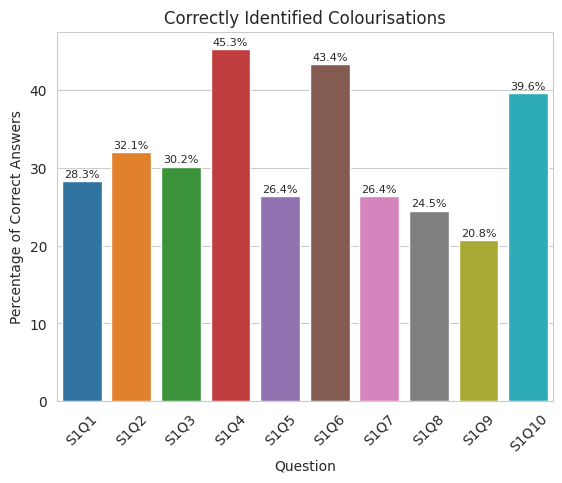

In [ ]:
# Iterate over the dictionary items and calculate the percentage of correct answers for each column
percentages = {}
for column, answer in correct_answers.items():
    percentages[column] = (responses[column] == answer).mean() * 100

# Create a DataFrame from the percentages dictionary
df = pd.DataFrame.from_dict(percentages, orient='index', columns=['Percentage'])

# Reset the index and rename the column for better plot aesthetics
df = df.reset_index().rename(columns={'index': 'Question'})

# Plot the grouped bar plot using Seaborn
sns.set_style('whitegrid')
ax = sns.barplot(x='Question', y='Percentage', data=df)
plt.xlabel('Question')
plt.ylabel('Percentage of Correct Answers')
plt.title('Correctly Identified Colourisations')
plt.xticks(rotation=45)

# Add percentage labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2, 
        height + .5,
        f'{height:.1f}%', 
        ha='center',
        fontsize=8
    )

plt.savefig('./results/ae/correct_col.png')
plt.show()

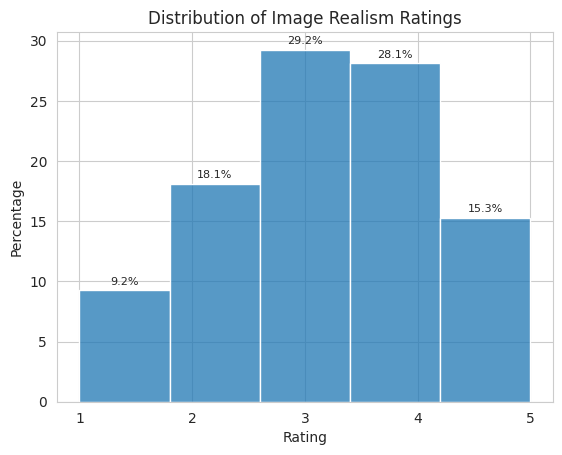

Average Rating: 3


In [ ]:
import numpy as np

# Create a list of column names for the ratings
realism_questions = ['S2Q1', 'S2Q2', 'S2Q3', 'S2Q4', 'S2Q5', 'S2Q6', 'S2Q7', 'S2Q8', 'S2Q9', 'S2Q10']

# Extract the ratings from the responses dataframe
ratings = responses[realism_questions].values.ravel()

# Create the histogram
ax = sns.histplot(x=ratings, kde=False, stat='percent', bins=5)

# Set the axis labels and title
plt.xlabel('Rating')
plt.ylabel('Percentage')
plt.title('Distribution of Image Realism Ratings')
plt.xticks(np.arange(1, 6 ,1))

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2, 
        height + .5,
        f'{height:.1f}%', 
        ha='center',
        fontsize=8
    )

# Show the histogram
plt.savefig('./results/ae/ratings.png')
plt.show()

averate_rating = round(np.mean(ratings))
print(f'Average Rating: {averate_rating:.0f}')

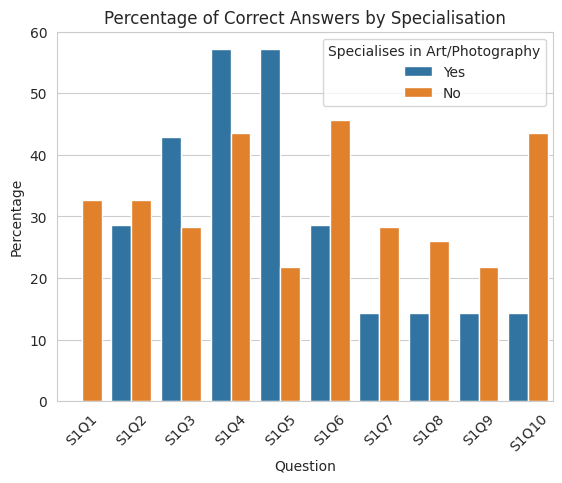

In [ ]:
import numpy as np

specialise_yes = responses.loc[responses['specialise'] == 'Yes']
specialise_no = responses.loc[responses['specialise'] == 'No']

# Calculate the percentages for 'Yes' and 'No' specialisations
percentages_yes = [(specialise_yes[column] == answer).mean() * 100 for column, answer in correct_answers.items()]
percentages_no = [(specialise_no[column] == answer).mean() * 100 for column, answer in correct_answers.items()]

# Get the question labels for the x-axis
question_labels = list(correct_answers.keys())

# Create a DataFrame for the data
data = pd.DataFrame({
    'Question': question_labels,
    'Yes': percentages_yes,
    'No': percentages_no
})

# Reshape the data for plotting
data = data.melt(id_vars='Question', var_name='Specialises in Art/Photography', value_name='Percentage')

# Plot the bar graph using Seaborn
sns.set_style('whitegrid')
sns.barplot(x='Question', y='Percentage', hue='Specialises in Art/Photography', data=data)

# Add labels and title
plt.xlabel('Question')
plt.ylabel('Percentage')
plt.title('Percentage of Correct Answers by Specialisation')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.savefig('./results/ae/correct_spec.png')
plt.show()

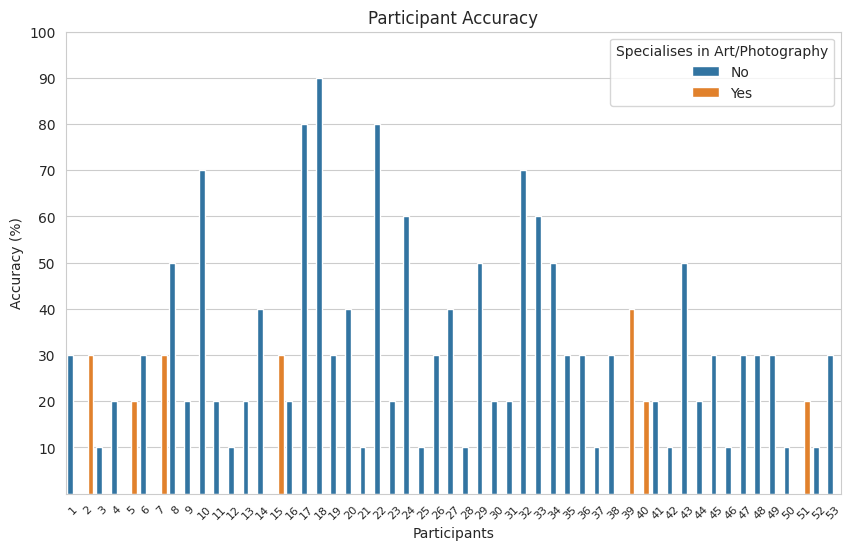

In [ ]:
import numpy as np

questions = responses[correct_answers.keys()]
# Calculate the number of correct answers for each participant
accuracy = questions.eq(correct_answers).mean(axis=1) * 100

# Create a new data frame with Participant and Accuracy columns
participant_accuracy = pd.DataFrame({'Participant': responses.index + 1, 'Accuracy': accuracy, 'Specialise': responses['specialise']})
participant_accuracy.to_csv('../survey/ae/participant_answers.csv', index=False)

# Plot the participant accuracy with specialised information using seaborn
sns.set_style(style='whitegrid')
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Participant', y='Accuracy', hue='Specialise', data=participant_accuracy)
ax.tick_params(axis='x', labelsize=8, rotation=45)
plt.xlabel('Participants')
plt.ylabel('Accuracy (%)')
plt.title('Participant Accuracy')
plt.legend(title='Specialises in Art/Photography', loc='upper right')
plt.yticks(np.arange(10, 110, 10))

plt.savefig('./results/ae/accuracy.png')
plt.show()

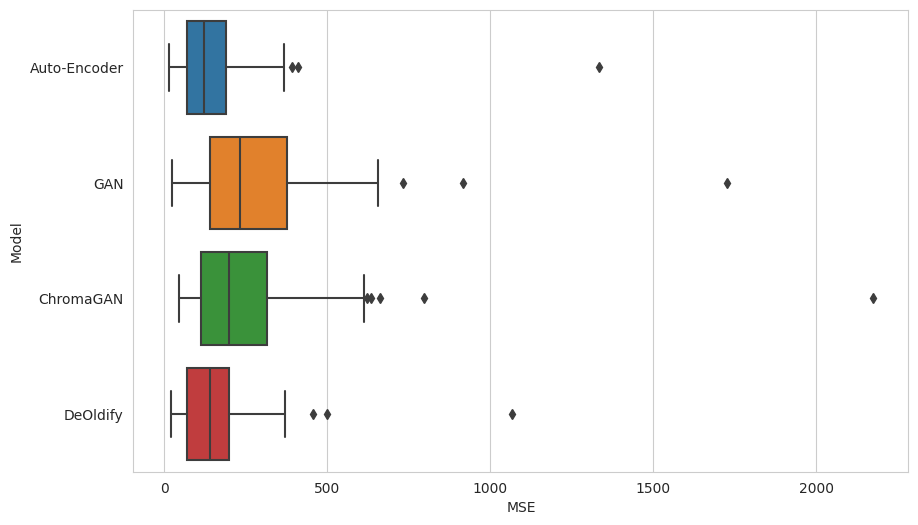

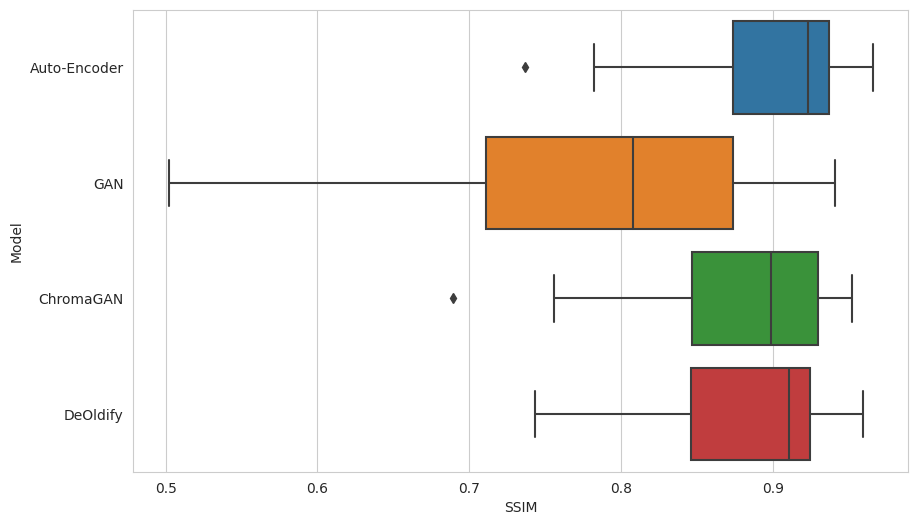

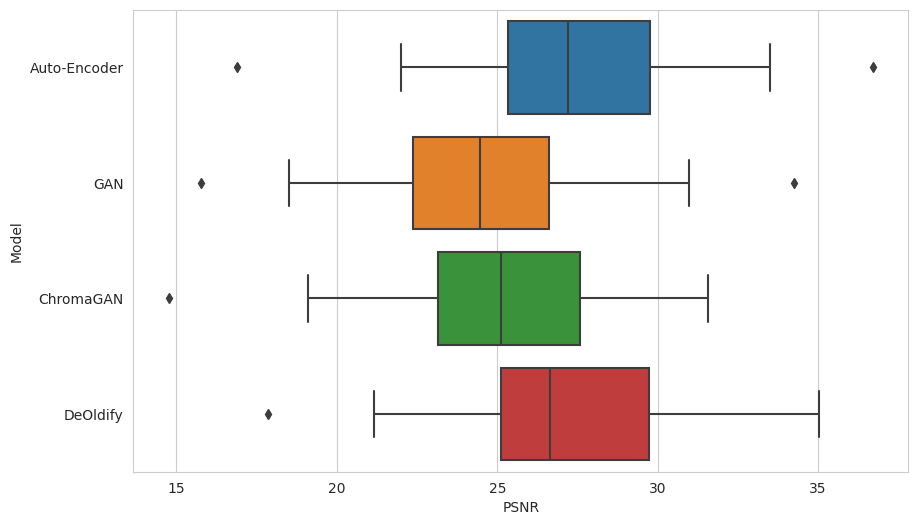

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataframes = []
model_names = ['Auto-Encoder', 'GAN', 'ChromaGAN', 'DeOldify']  # Add your model names here

for csv_file, model_name in zip(csv_files, model_names):
    df = pd.read_csv(csv_file)
    df['Model'] = model_name
    dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)

sns.set_style('whitegrid')

for metric in ['MSE', 'SSIM', 'PSNR']:
    plt.figure(figsize=(10,6))
    sns.boxplot(data=combined_df, x=metric, y="Model")
    plt.savefig(f'./results/metrics/{metric.lower()}.png')
    plt.show()

In [19]:
!python images.py "./samples/COLOUR" "./models/ae/16-05-2023/run_5/results/images/colourised" "./models/gan/27-05-2023/run_12/results/images/colourised" "./models/de_oldify/colourised" "./models/chroma_gan/colourised" --output "./results/comparison.png"

2023-05-31 17:29:16.685061: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 17:29:17.796153: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Figure(2500x25000)


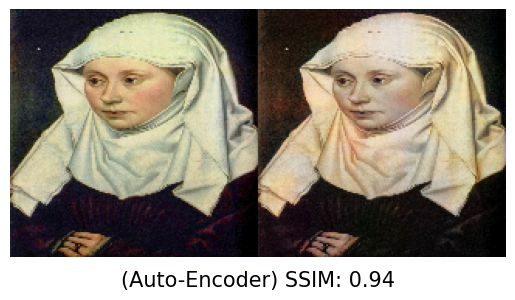

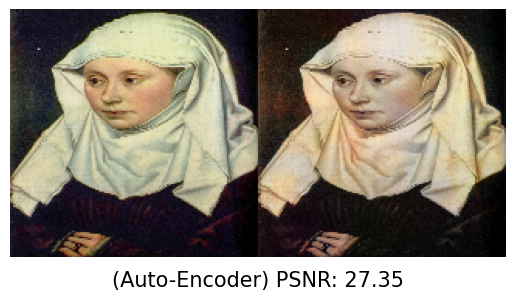

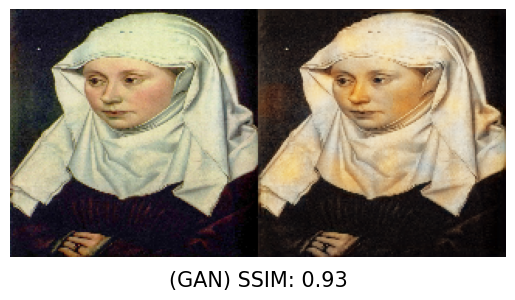

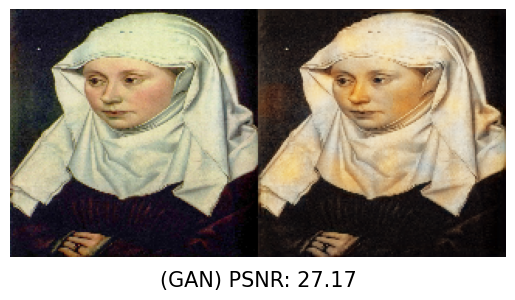

In [40]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage import io
import matplotlib.pyplot as plt
import cv2

gt = io.imread('./models/ae/16-05-2023/run_5/results/images/ground_truths/25.png')
col = io.imread('./models/ae/16-05-2023/run_5/results/images/colourised/25_col.png')
concat = cv2.hconcat([gt, col])

ssim_val = ssim(gt, col, channel_axis=2)
psnr_val = psnr(gt, col)

plt.imshow(concat)
plt.title(f'(Auto-Encoder) SSIM: {ssim_val:.2f}', y=-0.15, fontsize=15)
plt.axis(False)
plt.savefig('./ssim_eg_ae.png')
plt.show()

plt.imshow(concat)
plt.title(f'(Auto-Encoder) PSNR: {psnr_val:.2f}', y=-0.15, fontsize=15)
plt.axis(False)
plt.savefig('./psnr_eg_ae.png')
plt.show()

gt = io.imread('./models/gan/27-05-2023/run_12/results/images/ground_truths/25.png')
col = io.imread('./models/gan/27-05-2023/run_12/results/images/colourised/25_col.png')
concat = cv2.hconcat([gt, col])

ssim_val = ssim(gt, col, channel_axis=2)
psnr_val = psnr(gt, col)


plt.imshow(concat)
plt.title(f'(GAN) SSIM: {ssim_val:.2f}', y=-0.15, fontsize=15)
plt.axis(False)
plt.savefig('./ssim_eg_gan.png')
plt.show()

plt.imshow(concat)
plt.title(f'(GAN) PSNR: {psnr_val:.2f}', y=-0.15, fontsize=15)
plt.axis(False)
plt.savefig('./psnr_eg_gan.png')
plt.show()